In [1]:
# VAEによる飛沫カウントデータの予測

In [2]:
# ライブラリ

import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import ReLU, LeakyReLU, PReLU, ELU
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, TensorBoard
from keras.backend import clear_session
from sklearn.model_selection import StratifiedKFold

import random
import logging
import optuna
import datetime
from tqdm.notebook import tqdm
from cuml.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

2023-08-18 02:46:09.905113: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%%HTML
<style>
    div#notebook-container    { width: 65%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [4]:
def plot_timeSeries(timeSeries):
    """

    時系列データをプロットする．

    Parameters
    ----------
    timeSeries : numpy.ndarray or pandas.core.series.Series
        プロットしたい時系列データ．numpy.ndarrayの場合，次元は(N,)

    Returns
    ----------
    None
    """
    
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    
    ax.set(xlim=(0, len(timeSeries)-1), ylim=(min(timeSeries) - 0.05*(max(timeSeries)-min(timeSeries)), max(timeSeries) + 0.05*(max(timeSeries)-min(timeSeries))))
    ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
    ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())
    
    ax.plot(timeSeries, color="black", linestyle = "-", linewidth=1.0)
    plt.show()
    
    return

In [5]:
def split_dataset(dataframe, num_test=3):
    """

    時系列データをトレーニングデータとテストデータに分割する

    Parameters
    ----------
    dataframe : pandas.core.frame.DataFrame
       時系列データのDataFrame．indexがcase nameである必要がある．
    
    num_test : int
        各officeからテストデータとして抽出するケース数．デフォルトでは３

    Returns
    ----------     
    df_train : pandas.core.frame.DataFrame
         トレーニング用データ．
        
    df_test : pandas.core.frame.DataFrame
        テスト用データ．       
    
    Notes
    ----------
    テストデータの抽出方法は擬似的な層化抽出．
    各officeから指定した数のcaseをテストデータとして抽出する
    """
    
    office_list_dupl = [index.split(sep="_")[0] for index in dataframe.index.tolist()]
    office_list = sorted(set(office_list_dupl), key=office_list_dupl.index)
    
    df_test = pd.DataFrame()
    for office in office_list:
        df = dataframe.filter(like=office+"_", axis=0).sample(n=3, random_state=0)
        df_test = pd.concat([df_test, df])
        
    df_train = dataframe[~dataframe.index.isin(df_test.index)]
    
    return df_train, df_test

In [6]:
class Sampling(keras.layers.Layer):
    """
    VAEにおけるサンプリングレイヤー。
    tensorflow.kerasのlayers.Layerクラスを継承。
    
    Attributes
    ----------
    None
    """    
    
    def call(self, inputs):
        """
        Parameters
        ----------
        inputs : list
            サンプリングに用いる統計量の含まれたリスト。
            inputs[0]は潜在空間の平均，inputs[1]は潜在空間の分散の自然対数。
            
        Returns
        ----------
        z_sampled : numpy.ndarray
            サンプリングした潜在変数。
        """
        
        z_mean, z_log_var = inputs
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z_sampled = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        return z_sampled

In [7]:
def buildVAE(trial, z_dim):
    """
    VAEを構築する関数。

    Parameters
    ----------
    trial : optuna.trial.Trial
        最適化を行っているstudyのtrial

    z_dim : int
        潜在空間の次元数。エンコーダの出力の次元と等しくなる

    Returns
    ----------
    vae : keras.engine.functional.Functional
        構築したVAE
    """
    
    # モデル全体の設定
    
    l1 = trial.suggest_float("reg_l1", 0, 1)
    l2 = trial.suggest_float("reg_l2", 0, 1)
    
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.0005, 0.001, 0.005, 0.01])
    dropout_rate = trial.suggest_float("dropout", 0, 0.5)
    batch_size = trial.suggest_int("batch_size", 32, 256, 32)
    
    encoder = build_encoder(trial, z_dim)
    decoder = build_decoder(trial, z_dim)
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=trial.params["learning_rate"]))
    
    return vae

In [8]:
def build_encoder(trial, z_dim):
    """
    エンコーダを構築する関数。

    Parameters
    ----------
    trial : optuna.trial.Trial
        最適化を行っているstudyのtrial

    z_dim : int
        潜在空間の次元数。エンコーダの出力の次元と等しくなる

    Returns
    ----------
    encoder : keras.engine.functional.Functional
        構築したエンコーダ
        
    Note
    ----------
    層の数を固定して各層のユニット数のみを最適化している。
    （※レイヤー数を変えてしまうと、optunaの最適化項目がtrial毎に変化してしまい見通しが悪くなるため）
    """
    
    common_layer = 4
    separate_layer = 2
    
    regularizer = l1_l2(l1=trial.params["reg_l1"], l2=trial.params["reg_l2"])
    
    # モデル構築
    encoder_inputs = Input(shape=(601, ))
    
    for layer in range(common_layer):

        units = trial.suggest_int("encoder_layer{}_unit".format(layer), 128, 480, 32)
        
        if layer==0:
            x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(encoder_inputs)
        else:
            x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(x)
            
        x = ReLU()(x)
        
        if layer==common_layer-1:
            x_sep = Dropout(rate=trial.params["dropout"])(x)
        else:
            x = Dropout(rate=trial.params["dropout"])(x)
    
    output = {}
    
    for key in ["z_mean", "z_log_var"]:
        
        for layer in range(separate_layer):

            units = trial.suggest_int("encoder_{}_layer{}_unit".format(key, layer), 32, 128, 32)

            if layer==0:
                x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(x_sep)
            else:
                x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(x)

            x = ReLU()(x)
            x = Dropout(rate=trial.params["dropout"])(x)
            
        output[key] = x

    z_mean = Dense(z_dim, name="z_mean")(output["z_mean"])
    z_log_var = Dense(z_dim, name="z_log_var")(output["z_log_var"])
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    return encoder

In [9]:
def build_decoder(trial, z_dim):
    """
    エンコーダを構築する関数。

    Parameters
    ----------
    trial : optuna.trial.Trial
        最適化を行っているstudyのtrial

    z_dim : int
        潜在空間の次元数。エンコーダの出力の次元と等しくなる

    Returns
    ----------
    decoder : keras.engine.functional.Functional
        構築したデコーダ
        
    Note
    ----------
    層の数を固定して各層のユニット数のみを最適化している。
    """
    
    num_layer = 6
    
    regularizer = l1_l2(l1=trial.params["reg_l1"], l2=trial.params["reg_l2"])
    
    # モデル構築
    decoder_inputs = Input(shape=(z_dim, ))
    
    for layer in range(num_layer):

        units = trial.suggest_int("decoder_layer{}_unit".format(layer), 32, 480, 32)
        
        if layer==0:
            x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(decoder_inputs)
        else:
            x = Dense(units, kernel_initializer="he_normal", kernel_regularizer=regularizer)(x)
            
        x = ReLU()(x)
        x = Dropout(rate=trial.params["dropout"])(x)
            
    decoder_outputs = Dense(601, activation="sigmoid", kernel_initializer="glorot_normal")(x)
    
    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    
    return decoder

In [75]:
class VAE(keras.Model):
    """
    keras.Modelクラスを継承したサブクラス。
    
    Attributes
    ----------
    encoder : keras.engine.functional.Functional
        構築したencoderモデル。
        
    decoder : keras.engine.functional.Functional
        構築したdecoderモデル。
        
    total_loss_tracker : keras.metrics.base_metric.Mean
        total_loss_tracker（誤差の総和）を計算するためのインスタンス。

    reconstruction_loss_tracker : keras.metrics.base_metric.Mean
        reconstruction_loss_tracker（再構成誤差）を計算するためのインスタンス。

    kl_loss_tracker : keras.metrics.base_metric.Mean
        kl_loss_tracker（KLダイバージェンス）を計算するためのインスタンス。
    """    
    
    def __init__(self, encoder, decoder, **kwargs):
        """
        インスタンス化の際に呼ばれる初期化関数。
        
        Parameters
        ----------
        encoder : keras.engine.functional.Functional
            構築したencoderモデル。
        
        decoder : keras.engine.functional.Functional
            構築したdecoderモデル。
            
        Returns
        ----------
        None
        """
        
        # 親クラスのメソッドによる初期化
        super().__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        metricsのオーバーライドメソッド。
        
        Parameters
        ----------
        None
            
        Returns
        ----------
        metrics_list : list
            インスタンスに属している誤差関数のリスト。総和誤差、再構成誤差、KLダイバージェンスの順に格納されている。
        
        Note
        ----------
        property属性なのでsetterと同じ役割を持つ。
        正直良くわかっていないが、Keraにおいて内部的に呼ばれるだけの関数なので余り気にしない。
        """
        
        metrics_list = [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
        
        return metrics_list

    def train_step(self, data):
        """
        train_stepのオーバーライドメソッド。
        
        Parameters
        ----------
        data : tensorflow.python.framework.ops.Tensor
            学習に用いるデータ（多分）。
            
        Returns
        ----------
        loss_map : dict
            損失関数の辞書
            
        Note
        ----------
        損失関数・勾配の計算，重みの更新を行うメソッド。
        名前や中身的にエポック毎やバッチ毎に呼び出されるのかと思いきやそうではない。
        """
        
        # loss
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        # gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        loss_map = {
                    "loss": self.total_loss_tracker.result(),
                    "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                    "kl_loss": self.kl_loss_tracker.result(),
                   }

        return loss_map
    
    def evaluate(self, x, batch_size):
        """
        evaluateのオーバーライドメソッド。
        
        Parameters
        ----------
        x : pandas.core.frame.DataFrame
            評価に用いるデータ。
            
        batch_size : int
            バッチサイズ。
            
        Returns
        ----------
        score_list : list
            評価関数のscoreのリスト
            
        Note
        元のreconstruction_lossはバッチ毎に総和をとってから平均している。
        バッチ毎の入力方法がわからないので，データ数の割合で補正している（これで良いのかは知らん）。
        ----------
        
        """
        
        z_mean, z_log_var, z = self.encoder(x)

        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_sum(keras.losses.binary_crossentropy(x, reconstruction))
        reconstruction_loss = reconstruction_loss * (batch_size/len(x))

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        score_list = [total_loss, reconstruction_loss, kl_loss]
        
        return score_list
    
    def predict(self, x):
        """
        predictのオーバーライドメソッド。
        
        Parameters
        ----------
        x : pandas.core.frame.DataFrame
            評価に用いるデータ。
            
        Returns
        ----------
        reconstruction : numpy.ndarray
            入力を再構築したデータ
            
        Note
        オーバーライドせずに済む方法がわからないので力技で解決。
        解決法が分かり次第改善するべき。
        ----------
        
        """
        
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder.predict(z)
        
        return reconstruction

In [11]:
class Objective(object):
    """
    optunaの最適化の目的関数クラス。
    
    Attributes
    ----------
    X_train : pandas.core.frame.DataFrame
        学習に用いるデータ．

    z_dim : int
        潜在空間の次元

    bar : tqdm.std.tqdm, tqdm.notebook.tqdm_notebook
        optunaによる最適化の進捗を可視化するプログレスバー
    """
    
    
    def __init__(self, X_data, z_dim):
        """
        Parameters
        ----------
        X_train : pandas.core.frame.DataFrame
            学習に用いるデータ
            
        z_dim : int
            潜在空間の次元

        bar : tqdm.std.tqdm, tqdm.notebook.tqdm_notebook
            optunaによる最適化の進捗を可視化するプログレスバー
        """
    
        self.X_data = X_data
        self.z_dim = z_dim
        self.bar = tqdm(total=n_trials, initial=0)
        
        
    def __call__(self, trial):
        """

        optunaによって呼び出される目的関数

        Parameters
        ----------
        trial : optuna.trial.Trial
            最適化を行っているstudyのtrial

        Returns
        ----------
        score : float
            交差検証の結果の平均をとったもの
        """
        
        model = buildVAE(trial, z_dim)

        scores = self.model_varidation(trial, model, 8)
        
        self.bar.update()
        self.bar.refresh()

        keras.backend.clear_session()
        
        return scores.mean()
    
    
    def model_varidation(self, trial, model, n_sprits=10):
        """

        __call__によって呼ばれる交差検証用関数。
        交差検証はテストケースにあわせて層化n分割考査検証を採用。

        Parameters
        ----------
        trial : optuna.trial.Trial
            最適化を行っているstudyのtrial。
            
        model : keras.engine.functional.Functional
            検証を行うモデル。
            
        n_sprirts : int
            交差検証の分割数。デフォルトでは10。

        Returns
        ----------
        scores : numpy.ndarray
            交差検証の結果。各検証での損失関数の値を持つ。
        """
        
        X_data = self.X_data.copy()
        
        if ("office" in X_data.columns.tolist())==False:
            X_data.insert(0, "office", [index.split(sep="_")[0] for index in X_data.index.tolist()])
        
        kf = StratifiedKFold(n_splits=n_sprits, shuffle=True, random_state=42)
            
        early_stopping = EarlyStopping(monitor="loss", min_delta=0, patience=30, verbose=0, mode="min")
    
        scores = np.array([])
        for train_indices, valid_indices in kf.split(X_data, X_data["office"]):
        
            X_train = X_data.iloc[train_indices].drop(labels="office", axis=1)
            X_val = X_data.iloc[valid_indices].drop(labels="office", axis=1)
            
            model.fit(x=X_train.values, epochs=300, batch_size=trial.params["batch_size"], verbose=0, callbacks=[early_stopping])
            
            score = model.evaluate(x=X_val.values, batch_size=trial.params["batch_size"])
            scores = np.append(scores, score[0])
            
        print("\n")
            
        return scores

In [12]:
def optuna_outputDir():
    """
    optunaのログファイルとデータベースファイルの出力ディレクトリを作成する

    Parameters
    ----------
    None

    Returns
    ----------
    optuna_storageFile : str
        dbファイルへのpath

    optuna_logDir : str
        logファイルの出力ディレクトリへのpath
    """
    
    path = os.getcwd()
    
    optuna_storageDir = os.path.join(path, "optuna_dashboard")
    optuna_storageFile = "sqlite:///{}/database.db".format(optuna_storageDir)
    os.makedirs(optuna_storageDir, exist_ok=True)
    
    optuna_logDir = os.path.join(path, "log")
    os.makedirs(optuna_logDir, exist_ok=True)
    
    return optuna_storageFile, optuna_logDir

In [13]:
def tensorboard_outputDir(casename="Unknown_case"):
    """

    tensorboardの出力ディレクトリを作成する

    Parameters
    ----------
    casename : str
        学習するケース名。モデル名でもなんでもいい。

    Returns
    ----------
    tensorboard_logDir : str
        出力するディレクトリへのpath。
    """
    
    now = datetime.datetime.now()
    date = now.strftime("%Y_%m_%d")
    current_time = now.strftime("%H_%M_%S")
    
    path = os.getcwd()
    
    tensorboard_logDir = os.path.join(path, "tensorboard_log")
    os.makedirs(tensorboard_logDir, exist_ok=True)
    
    tensorboard_logDir = os.path.join(tensorboard_logDir, "{}_{}_{}".format(date, casename, current_time))
    os.makedirs(tensorboard_logDir, exist_ok=True)
    
    return tensorboard_logDir

In [14]:
# main

In [15]:
# 準備

In [16]:
# カウント時系列データの読み込み

tsFilePath = "/mnt/data/office/droplets/timeSeries_summary.csv"

timeSeries_df = pd.read_csv(tsFilePath, header=0, index_col=0)

In [17]:
timeSeries_df

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_0,10000.0,9440.0,8637.6,7401.2,7429.4,7469.8,7396.6,7226.4,6953.4,6886.6,...,774.8,768.8,759.0,749.4,742.8,739.4,737.2,735.2,733.0,729.0
office1_0_123_aout,10000.0,8934.6,8686.8,8319.8,7266.2,6929.6,6718.6,6530.8,6046.0,5983.6,...,1276.6,1269.6,1267.6,1269.6,1272.2,1271.4,1270.0,1264.6,1261.6,1256.4
office1_0_123_bout,10000.0,9384.8,8704.2,8247.2,8070.0,7683.8,7532.0,7366.4,7353.2,7176.0,...,1819.0,1823.2,1838.4,1862.4,1867.2,1856.8,1836.0,1840.0,1842.6,1839.4
office1_0_164_aout,10000.0,9652.0,8918.4,7770.8,6946.2,6767.4,6619.8,6774.4,6651.6,6533.2,...,1151.0,1154.0,1152.8,1151.8,1151.2,1153.8,1158.8,1162.4,1164.8,1168.6
office1_0_164_bout,10000.0,8477.0,8021.2,6260.4,6128.4,5789.4,5506.0,5364.8,5406.8,5408.0,...,1742.2,1743.0,1747.2,1759.8,1763.2,1766.2,1773.0,1776.2,1776.8,1785.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office33_960_164_bout,10000.0,9788.4,8094.6,6839.6,6133.0,5318.8,4789.4,4516.8,4392.2,4177.8,...,1993.6,1990.8,1992.0,1993.6,1996.2,1997.2,1995.0,1994.6,1993.6,1992.2
office33_960_246_aout,10000.0,9661.2,7803.6,6648.2,5643.8,4805.8,4289.6,3970.8,3816.0,3754.0,...,692.4,692.2,691.6,691.0,689.4,689.2,687.6,689.6,691.2,694.0
office33_960_246_bout,10000.0,9199.6,6938.8,5857.4,5087.8,4284.0,3963.8,3754.8,3506.4,3325.8,...,1386.8,1386.2,1388.0,1384.8,1385.8,1389.4,1389.0,1390.8,1392.2,1396.0
office33_960_82_aout,10000.0,9494.8,8076.2,6293.6,5508.4,4896.0,4524.4,4123.2,3817.2,3587.8,...,1674.4,1673.0,1675.0,1674.6,1676.6,1676.0,1676.8,1677.8,1688.4,1690.0


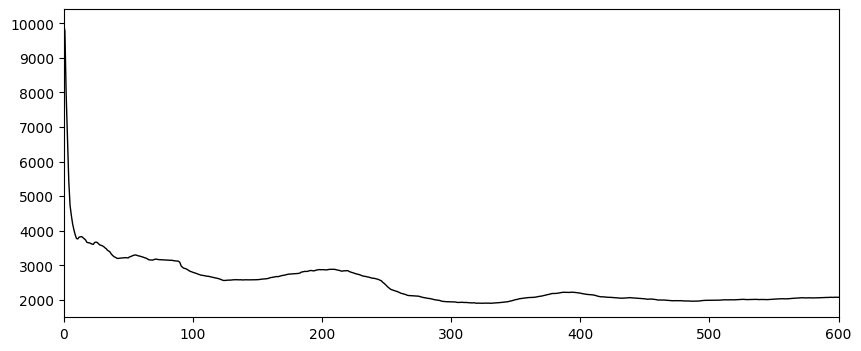

In [18]:
# 一応可視化しておく

plot_timeSeries(timeSeries_df.T["office21_960_246_bout"])

In [19]:
# 前処理

In [20]:
# 正規化
# 飛沫の観測数は必ず0~10000の間になるので正規化でいいのでは？という雑発想

timeSeries_df_norm = timeSeries_df.copy()

for columns in reversed(timeSeries_df.columns.tolist()):
    timeSeries_df_norm[columns] = timeSeries_df[columns]/timeSeries_df[timeSeries_df.columns.tolist()[0]]

In [21]:
timeSeries_df_norm

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_0,1.0,0.94400,0.86376,0.74012,0.74294,0.74698,0.73966,0.72264,0.69534,0.68866,...,0.07748,0.07688,0.07590,0.07494,0.07428,0.07394,0.07372,0.07352,0.07330,0.07290
office1_0_123_aout,1.0,0.89346,0.86868,0.83198,0.72662,0.69296,0.67186,0.65308,0.60460,0.59836,...,0.12766,0.12696,0.12676,0.12696,0.12722,0.12714,0.12700,0.12646,0.12616,0.12564
office1_0_123_bout,1.0,0.93848,0.87042,0.82472,0.80700,0.76838,0.75320,0.73664,0.73532,0.71760,...,0.18190,0.18232,0.18384,0.18624,0.18672,0.18568,0.18360,0.18400,0.18426,0.18394
office1_0_164_aout,1.0,0.96520,0.89184,0.77708,0.69462,0.67674,0.66198,0.67744,0.66516,0.65332,...,0.11510,0.11540,0.11528,0.11518,0.11512,0.11538,0.11588,0.11624,0.11648,0.11686
office1_0_164_bout,1.0,0.84770,0.80212,0.62604,0.61284,0.57894,0.55060,0.53648,0.54068,0.54080,...,0.17422,0.17430,0.17472,0.17598,0.17632,0.17662,0.17730,0.17762,0.17768,0.17858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office33_960_164_bout,1.0,0.97884,0.80946,0.68396,0.61330,0.53188,0.47894,0.45168,0.43922,0.41778,...,0.19936,0.19908,0.19920,0.19936,0.19962,0.19972,0.19950,0.19946,0.19936,0.19922
office33_960_246_aout,1.0,0.96612,0.78036,0.66482,0.56438,0.48058,0.42896,0.39708,0.38160,0.37540,...,0.06924,0.06922,0.06916,0.06910,0.06894,0.06892,0.06876,0.06896,0.06912,0.06940
office33_960_246_bout,1.0,0.91996,0.69388,0.58574,0.50878,0.42840,0.39638,0.37548,0.35064,0.33258,...,0.13868,0.13862,0.13880,0.13848,0.13858,0.13894,0.13890,0.13908,0.13922,0.13960
office33_960_82_aout,1.0,0.94948,0.80762,0.62936,0.55084,0.48960,0.45244,0.41232,0.38172,0.35878,...,0.16744,0.16730,0.16750,0.16746,0.16766,0.16760,0.16768,0.16778,0.16884,0.16900


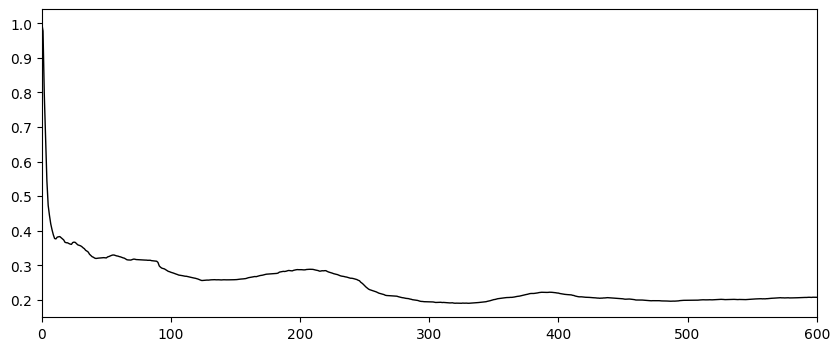

In [22]:
plot_timeSeries(timeSeries_df_norm.T["office21_960_246_bout"])

In [23]:
# データ分割

traindata, testdata = split_dataset(timeSeries_df_norm)

In [24]:
traindata

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_0,1.0,0.94400,0.86376,0.74012,0.74294,0.74698,0.73966,0.72264,0.69534,0.68866,...,0.07748,0.07688,0.07590,0.07494,0.07428,0.07394,0.07372,0.07352,0.07330,0.07290
office1_0_123_aout,1.0,0.89346,0.86868,0.83198,0.72662,0.69296,0.67186,0.65308,0.60460,0.59836,...,0.12766,0.12696,0.12676,0.12696,0.12722,0.12714,0.12700,0.12646,0.12616,0.12564
office1_0_123_bout,1.0,0.93848,0.87042,0.82472,0.80700,0.76838,0.75320,0.73664,0.73532,0.71760,...,0.18190,0.18232,0.18384,0.18624,0.18672,0.18568,0.18360,0.18400,0.18426,0.18394
office1_0_164_aout,1.0,0.96520,0.89184,0.77708,0.69462,0.67674,0.66198,0.67744,0.66516,0.65332,...,0.11510,0.11540,0.11528,0.11518,0.11512,0.11538,0.11588,0.11624,0.11648,0.11686
office1_0_205_aout,1.0,0.95024,0.88394,0.82964,0.76732,0.75140,0.67886,0.66114,0.65448,0.65452,...,0.09096,0.09102,0.09078,0.09102,0.09124,0.09104,0.09110,0.09134,0.09166,0.09134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office33_960_164_bout,1.0,0.97884,0.80946,0.68396,0.61330,0.53188,0.47894,0.45168,0.43922,0.41778,...,0.19936,0.19908,0.19920,0.19936,0.19962,0.19972,0.19950,0.19946,0.19936,0.19922
office33_960_246_aout,1.0,0.96612,0.78036,0.66482,0.56438,0.48058,0.42896,0.39708,0.38160,0.37540,...,0.06924,0.06922,0.06916,0.06910,0.06894,0.06892,0.06876,0.06896,0.06912,0.06940
office33_960_246_bout,1.0,0.91996,0.69388,0.58574,0.50878,0.42840,0.39638,0.37548,0.35064,0.33258,...,0.13868,0.13862,0.13880,0.13848,0.13858,0.13894,0.13890,0.13908,0.13922,0.13960
office33_960_82_aout,1.0,0.94948,0.80762,0.62936,0.55084,0.48960,0.45244,0.41232,0.38172,0.35878,...,0.16744,0.16730,0.16750,0.16746,0.16766,0.16760,0.16768,0.16778,0.16884,0.16900


In [25]:
testdata

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_164_bout,1.0,0.84770,0.80212,0.62604,0.61284,0.57894,0.55060,0.53648,0.54068,0.54080,...,0.17422,0.17430,0.17472,0.17598,0.17632,0.17662,0.17730,0.17762,0.17768,0.17858
office1_960_123_bout,1.0,0.85128,0.83802,0.59270,0.59780,0.54302,0.46560,0.45222,0.44532,0.43772,...,0.09530,0.09498,0.09446,0.09430,0.09418,0.09416,0.09386,0.09336,0.09284,0.09292
office1_960_164_aout,1.0,0.81840,0.72310,0.45876,0.41710,0.36322,0.33956,0.31208,0.30182,0.34608,...,0.09476,0.09570,0.09582,0.09578,0.09608,0.09626,0.09620,0.09654,0.09678,0.09720
office2_0_164_bout,1.0,0.97020,0.89410,0.85322,0.86680,0.81336,0.80744,0.79632,0.78986,0.76608,...,0.18558,0.18628,0.18738,0.19108,0.19128,0.19116,0.19094,0.19132,0.19180,0.19172
office2_960_164_aout,1.0,0.97144,0.87798,0.82962,0.70222,0.67504,0.65688,0.64710,0.63876,0.62526,...,0.12644,0.12646,0.12604,0.12360,0.12218,0.12108,0.12098,0.12062,0.11958,0.11884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office32_960_164_aout,1.0,0.97842,0.81984,0.68404,0.64460,0.60800,0.59806,0.57370,0.55766,0.53648,...,0.18484,0.18368,0.18298,0.18296,0.18146,0.18132,0.18128,0.18142,0.18138,0.18150
office32_660_0,1.0,0.98912,0.84222,0.74330,0.66584,0.63028,0.61500,0.60398,0.57912,0.56456,...,0.20252,0.20170,0.20114,0.20080,0.19976,0.19904,0.19816,0.19776,0.19710,0.19620
office33_0_164_bout,1.0,0.98592,0.84082,0.72566,0.61758,0.55868,0.52720,0.50426,0.47366,0.45942,...,0.13898,0.13874,0.13828,0.13760,0.13734,0.13762,0.13772,0.13800,0.13784,0.13754
office33_960_164_aout,1.0,0.95980,0.76042,0.60296,0.53684,0.50470,0.48452,0.47548,0.46344,0.44650,...,0.15544,0.15542,0.15544,0.15528,0.15528,0.15534,0.15550,0.15574,0.15562,0.15542


In [26]:
# 最適化

In [27]:
# optunaのログ設定

logger = logging.getLogger("optuna")
optuna.logging.disable_default_handler()

In [28]:
casename = "timeSeries_withRoI"
n_trials = 400

In [29]:
optuna_storageFile, optuna_logDir = optuna_outputDir()

In [30]:
# optunaによる探索

studies = {}

for z_dim in [2, 5, 10, 20, 30]:
    studyname = "{}_zdim{}".format(casename, z_dim)
    optuna_logFile = os.path.join(optuna_logDir, studyname)
    logger.addHandler(logging.FileHandler(optuna_logFile))
    
    objective = Objective(traindata, z_dim)
    
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler(), study_name=studyname, storage=optuna_storageFile, load_if_exists=True)
    study.optimize(objective, n_trials=n_trials)
    
    logger.removeHandler(logging.FileHandler(optuna_logFile))
    
    studies["zdim_{}".format(z_dim)] = study

  0%|          | 0/400 [00:00<?, ?it/s]

2023-08-18 02:46:16.859154: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 02:46:16.906523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:06:00.0, compute capability: 8.6
2023-08-18 02:46:20.014000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:648] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-18 02:46:20.057775: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe9d8216560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
202

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [111]:
studies

{'zdim_2': <optuna.study.study.Study at 0x7fea1394edc0>,
 'zdim_5': <optuna.study.study.Study at 0x7fea13a228e0>,
 'zdim_10': <optuna.study.study.Study at 0x7fe9f9527400>,
 'zdim_20': <optuna.study.study.Study at 0x7fe9d0437c10>,
 'zdim_30': <optuna.study.study.Study at 0x7fe66800ac70>}

In [112]:
best_trial = studies["zdim_2"].best_trial

In [113]:
best_trial

FrozenTrial(number=162, state=TrialState.COMPLETE, values=[14.215009689331055], datetime_start=datetime.datetime(2023, 8, 18, 4, 26, 49, 167676), datetime_complete=datetime.datetime(2023, 8, 18, 4, 28, 3, 89914), params={'batch_size': 32, 'decoder_layer0_unit': 160, 'decoder_layer1_unit': 480, 'decoder_layer2_unit': 320, 'decoder_layer3_unit': 32, 'decoder_layer4_unit': 288, 'decoder_layer5_unit': 288, 'dropout': 0.4187892564747437, 'encoder_layer0_unit': 352, 'encoder_layer1_unit': 384, 'encoder_layer2_unit': 160, 'encoder_layer3_unit': 160, 'encoder_z_log_var_layer0_unit': 64, 'encoder_z_log_var_layer1_unit': 96, 'encoder_z_mean_layer0_unit': 64, 'encoder_z_mean_layer1_unit': 64, 'learning_rate': 0.01, 'reg_l1': 0.7638447238889805, 'reg_l2': 0.9193782918840027}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'batch_size': IntDistribution(high=256, log=False, low=32, step=32), 'decoder_layer0_unit': IntDistribution(high=480, log=False, low=32, step=32), 'decode

In [114]:
best_trial.params

{'batch_size': 32,
 'decoder_layer0_unit': 160,
 'decoder_layer1_unit': 480,
 'decoder_layer2_unit': 320,
 'decoder_layer3_unit': 32,
 'decoder_layer4_unit': 288,
 'decoder_layer5_unit': 288,
 'dropout': 0.4187892564747437,
 'encoder_layer0_unit': 352,
 'encoder_layer1_unit': 384,
 'encoder_layer2_unit': 160,
 'encoder_layer3_unit': 160,
 'encoder_z_log_var_layer0_unit': 64,
 'encoder_z_log_var_layer1_unit': 96,
 'encoder_z_mean_layer0_unit': 64,
 'encoder_z_mean_layer1_unit': 64,
 'learning_rate': 0.01,
 'reg_l1': 0.7638447238889805,
 'reg_l2': 0.9193782918840027}

In [115]:
best_trial.values

[14.215009689331055]

In [116]:
model = buildVAE(best_trial, 2)

In [117]:
tensorboard_logDir = tensorboard_outputDir(casename="{}_zdim2".format(casename))

In [118]:
early_stopping = EarlyStopping(monitor="loss", min_delta=0, patience=30, verbose=0, mode="min")
tensorboard = TensorBoard(log_dir=tensorboard_logDir, write_graph=True, write_images=True, write_steps_per_second=True, update_freq="epoch")

In [119]:
history = model.fit(x=traindata.values, epochs=300, batch_size=best_trial.params["batch_size"], verbose=1, callbacks=[early_stopping, tensorboard])

Epoch 1/300
26/26 [==============================] - 7s 13ms/step - loss: 1178.2323 - reconstruction_loss: 354.6382 - kl_loss: 167.4497
Epoch 2/300
26/26 [==============================] - 0s 10ms/step - loss: 14.6515 - reconstruction_loss: 14.0037 - kl_loss: 0.0942
Epoch 3/300
26/26 [==============================] - 0s 10ms/step - loss: 14.2885 - reconstruction_loss: 13.8780 - kl_loss: 0.0011
Epoch 4/300
26/26 [==============================] - 0s 10ms/step - loss: 14.0813 - reconstruction_loss: 13.8593 - kl_loss: 1.1284e-04
Epoch 5/300
26/26 [==============================] - 0s 9ms/step - loss: 14.3210 - reconstruction_loss: 13.8740 - kl_loss: 6.2454e-05
Epoch 6/300
26/26 [==============================] - 0s 8ms/step - loss: 14.1710 - reconstruction_loss: 13.8768 - kl_loss: 4.7729e-05
Epoch 7/300
26/26 [==============================] - 0s 10ms/step - loss: 14.1464 - reconstruction_loss: 13.8909 - kl_loss: 3.0030e-05
Epoch 8/300
26/26 [==============================] - 0s 11ms/ste

<AxesSubplot: >

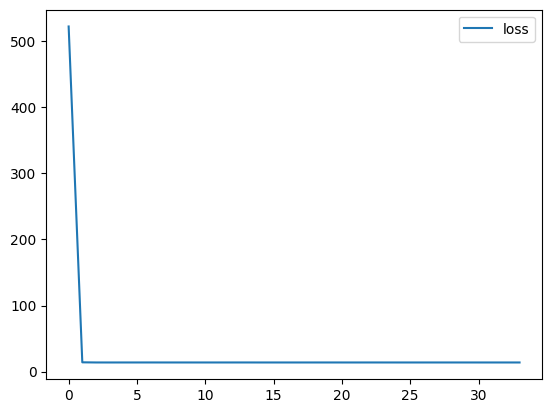

In [120]:
pd.DataFrame(history.history)[["loss"]].plot()

In [121]:
%load_ext tensorboard
%tensorboard --logdir $tensorboard_logDir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [143]:
predict_train = pd.DataFrame(data=model.predict(traindata.values), index=traindata.index.tolist(), columns=traindata.columns.tolist(), dtype="float")

26/26 [==============================] - 0s 2ms/step


In [144]:
predict_train

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_0,0.99984,0.939386,0.805446,0.721517,0.663828,0.604260,0.580639,0.560172,0.522359,0.510045,...,0.110390,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_0_123_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.604260,0.580639,0.560172,0.522359,0.510045,...,0.110390,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_0_123_bout,0.99984,0.939386,0.805446,0.721517,0.663828,0.604260,0.580639,0.560172,0.522359,0.510045,...,0.110390,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_0_164_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.604260,0.580639,0.560172,0.522359,0.510045,...,0.110390,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_0_205_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.604260,0.580639,0.560172,0.522359,0.510045,...,0.110390,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office33_960_164_bout,0.99984,0.939391,0.805453,0.721520,0.663826,0.604264,0.580637,0.560167,0.522358,0.510042,...,0.110384,0.110060,0.110010,0.110161,0.109949,0.110247,0.110291,0.109835,0.109978,0.110145
office33_960_246_aout,0.99984,0.939391,0.805453,0.721520,0.663826,0.604264,0.580637,0.560167,0.522358,0.510042,...,0.110384,0.110060,0.110010,0.110161,0.109949,0.110247,0.110291,0.109835,0.109978,0.110145
office33_960_246_bout,0.99984,0.939391,0.805453,0.721520,0.663826,0.604264,0.580637,0.560167,0.522358,0.510042,...,0.110384,0.110060,0.110010,0.110161,0.109949,0.110247,0.110291,0.109835,0.109978,0.110145
office33_960_82_aout,0.99984,0.939391,0.805453,0.721520,0.663826,0.604264,0.580637,0.560167,0.522358,0.510042,...,0.110384,0.110060,0.110010,0.110161,0.109949,0.110247,0.110291,0.109835,0.109978,0.110145


In [145]:
predict_test = pd.DataFrame(data=model.predict(testdata.values), index=testdata.index.tolist(), columns=testdata.columns.tolist(), dtype="float")

3/3 [==============================] - 0s 2ms/step


In [146]:
predict_test

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
office1_0_164_bout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_960_123_bout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office1_960_164_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office2_0_164_bout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office2_960_164_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office32_960_164_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office32_660_0,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office33_0_164_bout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151
office33_960_164_aout,0.99984,0.939386,0.805446,0.721517,0.663828,0.60426,0.580639,0.560172,0.522359,0.510045,...,0.11039,0.110065,0.110019,0.110169,0.109955,0.110255,0.110299,0.109842,0.109983,0.110151


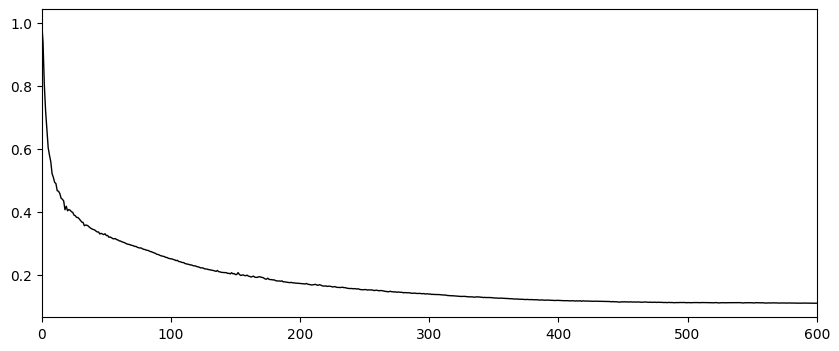

In [147]:
plot_timeSeries(predict_train.T["office21_960_246_bout"])

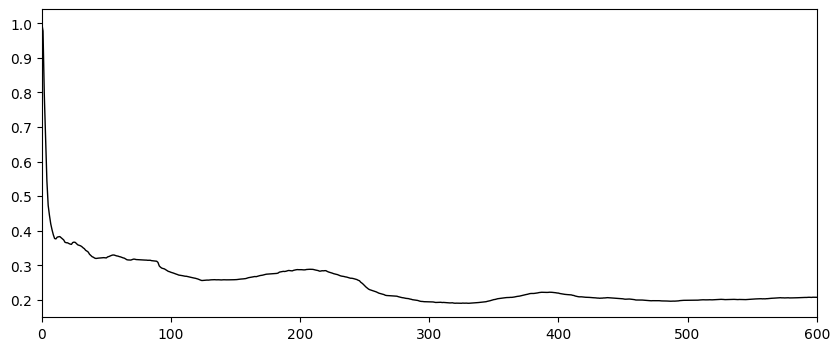

In [148]:
plot_timeSeries(traindata.T["office21_960_246_bout"])

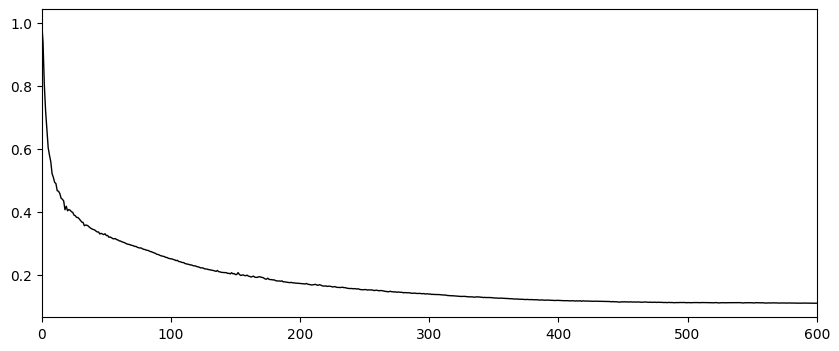

In [151]:
plot_timeSeries(predict_test.T["office32_960_164_aout"])

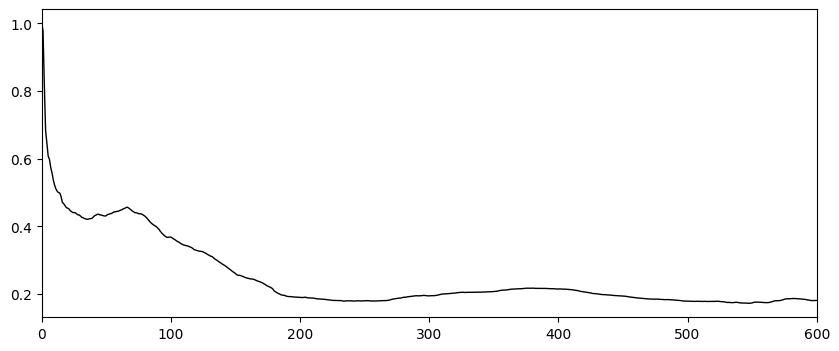

In [152]:
plot_timeSeries(testdata.T["office32_960_164_aout"])

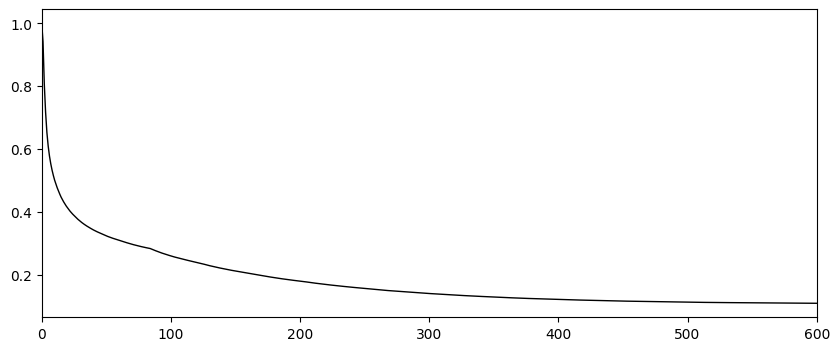

In [153]:
plot_timeSeries(traindata.mean())

In [154]:
result_train = model.evaluate(traindata.values, batch_size=best_trial.params["batch_size"])

In [155]:
result_train[0]

<tf.Tensor: shape=(), dtype=float32, numpy=14.216575>

In [156]:
result_test = model.evaluate(testdata.values, batch_size=best_trial.params["batch_size"])

In [157]:
result_test[0]

<tf.Tensor: shape=(), dtype=float32, numpy=14.478624>

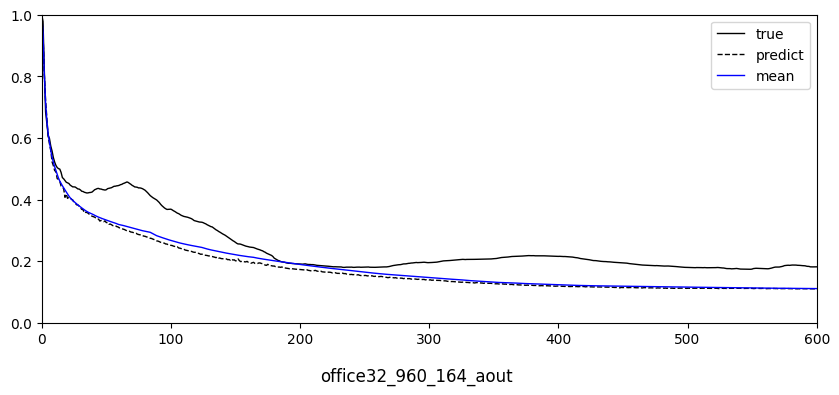

In [168]:
timeseries_true = testdata.T["office32_960_164_aout"]
timeseries_predict = predict_test.T["office32_960_164_aout"]
timeseries_mean = testdata.mean()

fig = plt.figure(figsize=(10, 4))
fig.suptitle("office32_960_164_aout", y=0)

ax = fig.add_subplot(111)

ax.set(xlim=(0, len(timeseries_true)-1), ylim=(0,1))
ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

ax.plot(timeseries_true, color="black", linestyle = "-", linewidth=1.0, label="true")
ax.plot(timeseries_predict, color="black", linestyle = "--", linewidth=1.0, label="predict")
ax.plot(timeseries_mean, color="blue", linestyle = "-", linewidth=1.0, label="mean")

ax.legend()
plt.show()